In [ ]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# <div class=consignes>Deep Learning et traitement du signal TP 1 </div>
<div class=consignes> L'objectif de ce TP est de prendre en main les outils de modélisation et d'analyse du signal présentés dans le premier cours et d'introduire la problématique de <it>détection</it> dont on parlera dans le cours numéro 3 </div>
<div class=consignes>Deadline : 18 octobre 2023, 11h59, par mail à deepetsignal.mva@gmail.com <br> Effort estimé : 2 à 3 heures maximum</div>
<div class=consignes>Le rendu de ce TP n'est pas obligatoire. Il permet d'obtenir un bonus de 1 (minimum syndical) à 3 (votre notebook servira de correction l'an prochain) points sur la moyenne des TP </div>

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp1.ipynb </div>

Balthazar Neveu

<div class=consignes>Si vous installez des paquets supplémentaires, merci de les lister dans la cellule suivante avec la syntaxe
    
```
!pip install \< nom_du_paquet \>
```
    
</div>

In [ ]:
!pip install interactive-pipe

In [2]:

import numpy as np 
import matplotlib.pylab as plt 
import scipy
import IPython.display as ipd
from scipy.signal import spectrogram
# %matplotlib notebook
from interactive_pipe.data_objects.curves import Curve
from interactive_pipe import interact
from interactive_pipe.data_objects.image import Image
import numpy as np 
import matplotlib.pylab as plt 

from interactive_pipe.data_objects.curves import Curve
from interactive_pipe import interactive, interactive_pipeline
from numpy.fft import fft,fftfreq,fftshift

## <div class=consignes>Partie 1: Audio </div>

### <div class=consignes>Visualisation</div>

 <div class=consignes>Enregistrez un fichier wav de quelques secondes de votre voix. 
  <br>
 Importez le avec scipy.io.wavfile.read et écoutez le dans le notebook avec IPython.display.Audio
</div>

In [3]:
rate, signal = scipy.io.wavfile.read("Voice.wav")
# rate, signal = scipy.io.wavfile.read("baby_maman_papa.wav")
ipd.Audio(signal, rate=rate)
# signal has 16 bits

<div class=consignes>Visualisez la forme d'onde temporelle de ce signal audio. <br>
Estimez et affichez sa Densité Spectrale de Puissance. <br>
Donnez une interprétation de ce que vous observez. 
</div>

# Visualisation de la forme d'onde et de la densité spectrale


On peut utiliser le code suivant basé sur la [librairie interactive_pipe](https://github.com/balthazarneveu/interactive_pipe) (que je maintiens)  afin de parcourir le signal.


## Voix cassée masculine

![dsp](illustrations/power_spectrum_density_broken_man_voice_44kHz.png)

- On observe des fréquences autour de 100Hz puis 200, 300, 400, 500 et 600Hz. 
- La fréquence contenant le plus de fréquence devrait naturellement être la plus faible/grave parmis ces harmoniques. 
- Il se trouve que j'ai la voix bien cassée en ce moment, ce qui rend l'analyse plus difficile.


## Voix de bébé
La voix est bien plus aïgue avec un pitch autour de 500Hz. La seconde harmonique apparaît autour de 1kHz. La fréquence fondamentale est celle qui a le plus de puissance.


![dsp](illustrations/baby_voice.png)

In [4]:
from interactive_pipe.helper import _private
_private.registered_controls_names = [] # this is for notebooks where you re-execute cells everytime.


def load_signal(path: str, global_params={}) -> np.array:
    rate, signal = scipy.io.wavfile.read(path)
    global_params["sampling_rate"] = rate
    return signal


@interactive(
    time_selection=(50., [0., 100.], "selected time [%]"), 
    window=(1., [0.01, 3.], "window size [s]")
)
def trim_signal(
    signal,
    time_selection: float=0.,
    window: float = 0.3,
    global_params={}
):
    rate = global_params["sampling_rate"]
    full_time = np.arange(len(signal))/rate
    full_signal = signal/(2.**15-1) # assume 16bits signed
    temporal_signal_length = len(signal)/rate
    time_center  = time_selection/100.*temporal_signal_length
    time_start = max(0,time_center-window/2.)
    time_end = min(temporal_signal_length, time_center+window/2.)
    index_start, index_end = int(time_start*rate), min(int(time_end*rate), len(signal))
    time = full_time[index_start:index_end] 
    current_signal = full_signal[index_start:index_end]
    global_params["time_start"] = time_start
    global_params["time_end"] = time_end 
    return time, current_signal



def visualize_signal(timeline, signal, global_params={}):
    curve = Curve(
        [
            (timeline, signal, "k-")
        ],
        grid=True,
        title=f"signal {global_params['time_start']:.2f} {global_params['time_end']:.2f}",
        xlim=(timeline[0], timeline[-1]),
        ylim=(-1., 1.),
        xlabel="t[s]",
        ylabel="Audio amplitude"
    )
    return curve


def visualize_fourier(frequencies, fourier_coefficients, global_params={}):
    freq_axis = frequencies[len(frequencies)//2:]
    amplitude_axis = np.abs(fourier_coefficients[len(frequencies)//2:])
    curve = Curve(
        [
            (freq_axis, amplitude_axis, "b-")
        ],
        grid=True,
        xlabel="f[Hz]",
        xlim=(0., 800.)
    )
    return curve

def compute_spectrum(x, global_params={}):
    fs = global_params["sampling_rate"]
    X= fft(x) / np.sqrt(len(x))
    f= fftfreq(len(x),d=1/fs)
    X_ordered = fftshift(X)
    f_ordered= fftshift(f)
    return f_ordered, np.abs(X_ordered)**2. #* fs

@interactive_pipeline(gui="nb", size=(10, 5))
def audio_pipeline(audio_path):
    full_audio_signal = load_signal(audio_path)
    trimmed_timeline, trimmed_audio = trim_signal(full_audio_signal)
    sig_viz = visualize_signal(trimmed_timeline, trimmed_audio)
    freq, ampl = compute_spectrum(trimmed_audio)
    spectrum = visualize_fourier(freq, ampl)
    return sig_viz, spectrum

audio_pipeline("Voice.wav")

interactive(children=(FloatSlider(value=50.0, description='selected time [%]', layout=Layout(width='500px'), s…

# Spectrogramme

<div class=consignes> Calculez et affichez le spectrogramme du signal. <br>
Justifiez du choix des réglages que vous avez faits. <br>
Sélectionnez une portion pertinente du spectrogramme pour estimer visuellement le pitch de votre voix.
    </div>

In [40]:
from ipywidgets import interact as interact_widg
from ipywidgets import fixed, FloatSlider
def plot_spectrogram(signal, sampling_rate, window_time=0.03, overlap_ratio=0.2):
    window = "hann"
    
    # Curve([(np.arange(len(selected_window))/rate, selected_window)], xlabel="Time[s]", ylabel="Waveform", grid=True).show(figsize=(15, 5))
    nperseg = int(window_time*sampling_rate)
    f, t, Sxx = spectrogram(
        signal,
        fs=rate,
        window=window,
        nperseg=nperseg,
        noverlap=int(overlap_ratio*nperseg)
        # nperseg=1024
    )
    Sxx = np.clip(Sxx, 1.E-15, None)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.title("Spectrogram")
    plt.colorbar(label='Intensity [dB]')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim(0., 2000.)

start=0.25
end = 3.5
selected_window = signal[int(start*rate):int(end*rate)]

# rate, signal = scipy.io.wavfile.read("baby_maman_papa.wav")
# rate, signal = scipy.io.wavfile.read("Voice.wav")
# selected_window=signal

# plot_spectrogram(selected_window, rate, window_time=0.005)
interact_widg(
    plot_spectrogram,
    signal=fixed(selected_window),
    sampling_rate=fixed(rate),
    window_time=FloatSlider(min=0.005, max=0.5, value=0.03, step=0.001),
    overlap_ratio=FloatSlider(min=0., max=0.95, value=0.2, step=0.01)
);

interactive(children=(FloatSlider(value=0.03, description='window_time', max=0.5, min=0.005, step=0.001), Floa…

In [92]:
from ipywidgets import interact as interact_widg
from ipywidgets import fixed, FloatSlider

def plot_spectrogram(signal, sampling_rate, window_time=0.03, overlap_ratio=0.2, silence_threshold=0.005):
    window = "hann"    
    # Curve([(np.arange(len(selected_window))/rate, selected_window)], xlabel="Time[s]", ylabel="Waveform", grid=True).show(figsize=(15, 5))
    nperseg = int(window_time*sampling_rate)
    f, t, Sxx = spectrogram(
        signal,
        fs=rate,
        window=window,
        nperseg=nperseg,
        noverlap=int(overlap_ratio*nperseg),
        scaling="spectrum"
        # nperseg=1024
    )
    Sxx = np.clip(Sxx, 1.E-15, None)
    
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')

    sliding_argmax = np.argmax(Sxx, axis=0)
    energy = np.array([Sxx[amax, idx] for idx, amax in enumerate(sliding_argmax)])
    silence_flag = np.sqrt(energy)<silence_threshold
    
    pitch = f[sliding_argmax]
    pitch[silence_flag] = np.NaN
    
    plt.plot(t, pitch, "r-", label="Pitch tracking")
    plt.title("Spectrogram")
    plt.colorbar(label='Intensity [dB]')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim(0., 1000.)
    plt.legend()


    time_axis = np.arange(len(signal))/sampling_rate
    current_freq = np.interp(time_axis, xp=t, fp=f[sliding_argmax])
    energy = np.array([Sxx[amax, idx] for idx, amax in enumerate(sliding_argmax)])
    energy[silence_flag] = 0. #np.NaN # DISCARD SILENCE
    current_amplitude = np.interp(time_axis, xp=t, fp=energy)
    current_amplitude = np.sqrt(current_amplitude)
    reconstructed_pitch_only = current_amplitude*np.sin(2.*np.pi*current_freq*time_axis)
    return time_axis, reconstructed_pitch_only


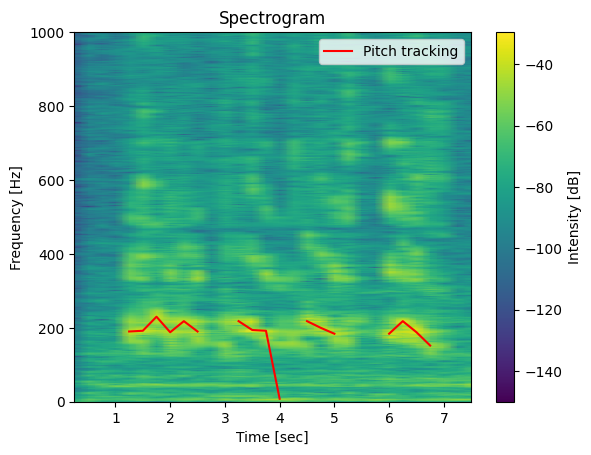

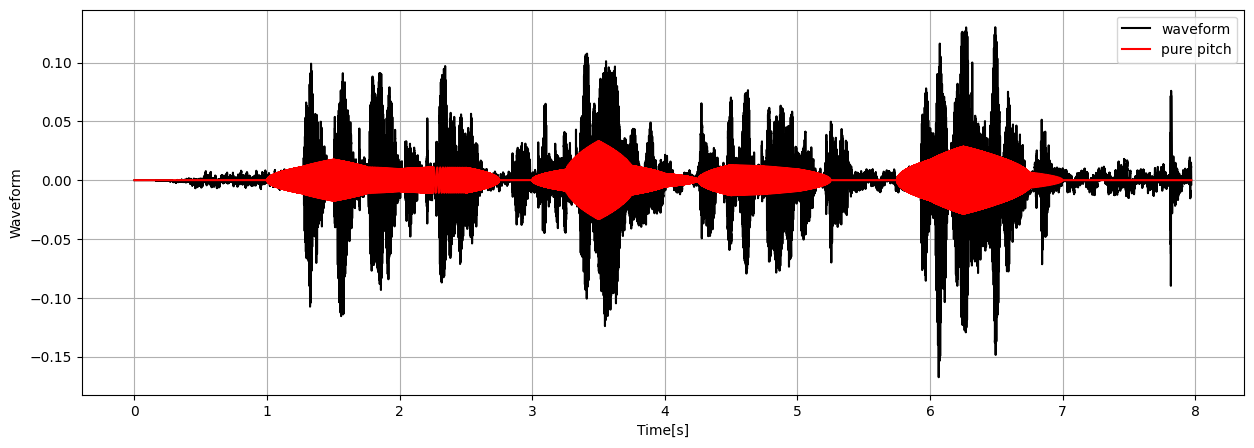

In [93]:
time_axis, reconstructed_pitch_only = plot_spectrogram(selected_window, rate, window_time=0.5, overlap_ratio=0.5)
Curve([
        (time_axis, selected_window, "k-", "waveform",),
        (time_axis, reconstructed_pitch_only, "r-", "pure pitch")
        ],
        xlabel="Time[s]", ylabel="Waveform", grid=True).show(figsize=(15, 5)
)

# Curve([(t, f[sliding_argmax])], xlabel="Time[s]", ylabel="Pitch evolution", grid=True).show(figsize=(15, 5))

In [89]:
ipd.Audio(np.round(reconstructed_pitch_only*(2.**15-1)).astype(np.int16), rate=rate)
# ipd.Audio(np.round(selected_window*(2.**15-1)).astype(np.int16), rate=rate)

In [86]:
start=0.25
end = 3.5
selected_window = signal[int(start*rate):int(end*rate)]/(2.**15-1.)

rate, signal = scipy.io.wavfile.read("baby_maman_papa.wav")
# rate, signal = scipy.io.wavfile.read("Voice.wav")
rate, signal = scipy.io.wavfile.read("voix_Mathilde.wav")
selected_window=signal/(2.**15-1.)

# plot_spectrogram(selected_window, rate, window_time=0.005)
interact_widg(
    plot_spectrogram,
    signal=fixed(selected_window),
    sampling_rate=fixed(rate),
    window_time=FloatSlider(min=0.005, max=0.5, value=0.03, step=0.001),
    overlap_ratio=FloatSlider(min=0., max=0.95, value=0.2, step=0.01),
    silence_threshold=FloatSlider(min=0., max=0.1, value=0.005, step=0.001),
);

interactive(children=(FloatSlider(value=0.03, description='window_time', max=0.5, min=0.005, step=0.001), Floa…

In [ ]:
start=0.
end = 4.
# start, end = 2.15, 2.45
# start, end= 1.3, 1.7
# start, end= 1.3, 2.5
# start, end= 8.3, 9.3
# start, end= 8.3, 12.

# for window in ["hamming", "boxcar"]:
# window = "hamming"
window = "hann"
selected_window = signal[int(start*rate):int(end*rate)]
Curve([(np.arange(len(selected_window))/rate, selected_window)], xlabel="Time[s]", ylabel="Waveform", grid=True).show(figsize=(15, 5))
f, t, Sxx = spectrogram(
    selected_window,
    fs=rate,
    window=window,
    nperseg=int(0.05*rate),
    # noverlap=200,
    # nperseg=1024
)
Sxx = np.clip(Sxx, 1.E-15, None)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Intensity [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
sliding_argmax = np.argmax(Sxx, axis=0)
plt.plot(t, f[sliding_argmax], "r-", label="Pitch tracking")
plt.ylim(0., 800.)
plt.legend()
plt.title('Spectrogram')
plt.show()

# sliding_argmax = np.argmax(Sxx, axis=0)
# Curve([f[sliding_argmax]], xlabel="Time[s]", ylabel="Waveform", grid=True).show(figsize=(15, 5))

In [ ]:
def find_pitch(input_signal, signal_rate):
    f, t, Sxx = spectrogram(
        input_signal,
        fs=signal_rate,
        window=window,
        # nperseg=int(0.05*signal_rate),
        nperseg=int(0.2*signal_rate),
        scaling="spectrum"
        # noverlap=200,
        # nperseg=1024
    )
    Sxx = np.clip(Sxx, 1.E-15, None)

    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='Intensity [dB]')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    sliding_argmax = np.argmax(Sxx, axis=0)
    plt.plot(t, f[sliding_argmax], "r-", label="Pitch tracking")
    plt.ylim(0., 800.)
    plt.legend()
    plt.title('Spectrogram')
    plt.show()



    sliding_argmax = np.argmax(Sxx, axis=0)
    time_axis = np.arange(len(input_signal))/signal_rate
    current_freq = np.interp(time_axis, xp=t, fp=f[sliding_argmax])
    energy = np.array([Sxx[amax, idx] for idx, amax in enumerate(sliding_argmax)])
    print(np.sqrt(energy))
    # energy = np.sum(Sxx, axis=0) # sum over the whole spectrum to mimick that the pitch got all the energy
    energy[np.sqrt(energy)<0.005] = 0. #np.NaN # DISCARD SILENCE
    current_amplitude = np.interp(time_axis, xp=t, fp=energy)
    current_amplitude = np.sqrt(current_amplitude)
    reconstructed_pitch_only = current_amplitude*np.sin(2.*np.pi*current_freq*time_axis)
    # print(current_amplitude.shape)
    Curve([
        (time_axis, input_signal, "k-", "waveform",),
        (time_axis, reconstructed_pitch_only, "r-", "pure pitch")
        ],
        xlabel="Time[s]", ylabel="Waveform", grid=True).show(figsize=(15, 5))
    Curve([(t, f[sliding_argmax])], xlabel="Time[s]", ylabel="Pitch evolution", grid=True).show(figsize=(15, 5))
    return reconstructed_pitch_only
time_stamps = np.arange(6000)/rate
freq = 1000.
# sine_wave = 200.*np.sin(2.*np.pi*freq*time_stamps) + 50.*np.sin(2.*np.pi*freq*10*time_stamps)
# find_pitch(sine_wave, rate)
reconstructed_pitch_only = find_pitch(selected_window/2.**16, rate)


In [ ]:
selected_window, np.round(reconstructed_pitch_only*(2.**15-1)).astype(np.int16)
q_signal = np.round(reconstructed_pitch_only*(2.**15-1)).astype(np.int16)
plt.plot(4*q_signal[3000:10000])
plt.plot(selected_window[3000:10000])

In [ ]:
selected_window

In [ ]:
ipd.Audio(selected_window, rate=rate)

In [ ]:
ipd.Audio(np.round(reconstructed_pitch_only*(2.**15-1)).astype(np.int16), rate=rate)

### <div class=consignes>Calcul du Pitch</div>

<div class=consignes>Proposez une méthode simple pour estimer automatiquement le Pitch de votre voix (cette méthode ne doit pas faire intervenir d'implémentations externes).

Utilisez cette méthode pour estimer les variations du Pitch le long du signal, estimez le pitch toutes les 20 ms et présentez vos résultats sous forme visuelle. 

Commentez.
    </div>

# Estimation automatique du pitch
- On peut espérer trouver l'argmax du spectrogramme selon l'axe des fréquences... 
Cette implémentation naïve conduite à une estimation trop aïgue du pitch pour ma voix assez grave... En effet le périodogramme laisse apparaître des harmoniques.
- Un détecteur de "silence" permet d'exclure simplement les zones sans vrai intérêt.

- Pour vérifier qualitativement que le pitch est estimé correctement, on peut ré-échantillonner une pure sinusoïde avec la fréquence choisie (et éventuellement modulée en amplitude par l'énergie du signal original).

In [ ]:
np.argmax(Sxx, axis=1)

## <div class=consignes>Partie 2: Détection d'impulsion </div>

<div class=consignes> Un signal de durée 1 seconde et échantillonné à 1000 Hz est composé d'un bruit blanc gaussien de puissance inconnue et éventuellement d'une impulsion à une fréquence f0 comprise entre 100 et 200 Hz. 
<br><br>
Une série de 1000 signaux est enregistrée dans le fichier signaux_impulsions.npz. 
Ouvez ce fichier avec numpy (cf code plus bas). Le fichier contient une tableau signaux 10000 x 1000 dont chaque ligne contient un signal de durée 1000. Le fichiez contient aussi un tableau labels de taille 10000 dont la ligne i est à TRUE si le signal i contient une impulsion et à 0 sinon. 

</div>

In [ ]:
donnees = np.load('signaux_impulsions.npz')
list(donnees.keys())
signaux = donnees['data']
labels = donnees['labels']

In [ ]:
signaux.shape, labels.shape

# Brainstrom 
Utiliser le max vs median ou moyenne?

In [ ]:
from interactive_pipe.data_objects.curves import Curve
from interactive_pipe import interact


def explore_curve(sample_index=0):
    current_signal = signaux[sample_index, :]
    time = np.arange(len(current_signal))
    squared_signal = current_signal**2
    energy_cum = np.cumsum(squared_signal)
    detect = labels[sample_index] == 1

    curve = Curve(
        [(time, current_signal, "g-" if detect else "r--")],
        grid=True,
        title=f"signal {sample_index}, {detect}",
        ylim=(-2., 2.)
    )
    curve_cum = Curve(
        [(time, energy_cum/energy_cum[-1], "b-"), (time, time/time[-1], "k--")],
        grid=True,
        title=f"signal {sample_index}, {int(labels[sample_index])}",
        ylim=(0., 1.)
    )
    return curve, curve_cum

interact(sample_index=(0, 10000-1, 10))(explore_curve)
# curve.show()

## <div class=consignes> Première méthode </div>

<div class=consignes> Proposez une méthode simple  pour décider si un signal contient une impulsion ou non à partir du calcul de l'énergie du signal. Cette méthode fera intervenir un seuil: 
</div>

```python
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
```

<div class=consignes>
Utilisez votre méthode avec un seuil fixé sur tous les signaux pour prédire s'ils contiennent une impulsion ou non. 
</div>

<div class=consignes>
Calculez: <br>
- VP = le nombre de signaux que vous détectez comme contenant une impulsion qui contiennet effectivement une impulsion <br>
- FP = le nombre de signaux que vous détectez comme contenant une impulsion qui ne contiennet en fait PAS une impulsion <br>
- VN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion qui ne contiennet effectivement PAS une impulsion<br>
- FN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion mais qui  contiennet en fait une impulsion
</div>

## <div class=consignes>Deuxième méthode </div>

<div class=consignes>Proposez une deuxième méthode faisant par exemple intervenir le spectrogramme du signal. Cette méthode fera encore intervenir un seuil
</div>

```python
def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
```


<div class=consignes> Calculez pour cette nouvelle méthode, pour un certain seuil les valeurs de VP, FP, VN, FN </div>

## <div class=consignes> Comparaison des méthodes </sdivs>

<div class=consignes>Pour une méthode de détection et un seuil donné, la précision est définie comme: 
$$ \frac{VP}{VP + FP}$$
et le rappel comme:
$$ \frac{VP}{VP +FN} $$
    
</div>

<div class=consignes> Donnez une interprétation de ces deux métriques </div>

<div class=consignes>
    Pour chacune des deux méthodes proposées, faites varier le seuil sur une dizaine de valeurs et calculez la précision et le rappel pour chacun de ces seuils. 

Affichez dans le plan (précision , rappel) les points de fonctionnement des deux méthodes pour différents seuils. <br>Commentez le résultat. 
    </div>